In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def simulate_noise_folding(fs1, fs2, fc, num_trials=100, N=100000):
    """
    仿真二阶IIR滤波器在下采样后的噪声折叠
    
    参数:
        b, a: 滤波器系数
        M: 下采样倍数
        N: 每轮仿真的样本数
        num_trials: 蒙特卡洛仿真轮数
    
    返回:
        各种噪声功率统计量
    """
    # 存储结果
    input_power = []
    output_power = []
    folded_power_estimates = []
    
    wn = 2 * fc / fs1
    b, a = signal.butter(2, wn, btype='low')
    M = int(fs1 / fs2)
    
    for trial in range(num_trials):
        # 1. 生成白噪声输入
        w = np.random.randn(N)  # 方差=1的零均值高斯白噪声
        
        # 2. 通过IIR滤波器
        x = signal.lfilter(b, a, w)
        
        # 3. 下采样
        y = x[::M]
        
        # 4. 计算功率
        P_in = np.var(w)  # 输入噪声功率
        P_out = np.var(y)  # 输出噪声功率
        
        # 5. 理论基带噪声功率（无混叠时的期望值）
        # 首先计算滤波器在基带[0, π/M]的增益
        omega = np.linspace(0, np.pi/M, 1000)
        _, H_freq = signal.freqz(b, a, omega)
        H_baseband = np.mean(np.abs(H_freq)**2)
        
        # 理论基带功率 = 输入功率 × 基带平均增益 / M
        P_baseband_theory = P_in * H_baseband / M
        
        # 6. 估算折叠功率 = 实际输出功率 - 理论基带功率
        P_folded_est = P_out - P_baseband_theory
        
        input_power.append(P_in)
        output_power.append(P_out)
        folded_power_estimates.append(max(0, P_folded_est))  # 避免负值
    
    return {
        'input_power_mean': np.mean(input_power),
        'output_power_mean': np.mean(output_power),
        'folded_power_mean': np.mean(folded_power_estimates),
        'folded_fraction': np.mean(folded_power_estimates) / np.mean(output_power),
        # 'folded_power_std': np.std(folded_power_estimates)
    }

# fs1 = 1000
# fs2 = 500
# fc = 200
# simulate_noise_folding(fs1, fs2, fc)

In [2]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def analyze_noise_folding_freq_corrected(fs1, fs2, fc, N_fft=4096):
    wn = 2 * fc / fs1
    b, a = signal.butter(2, wn, btype='low')
    M = int(fs1 / fs2)
    
    # 1. 计算滤波器的频率响应
    omega = np.linspace(0, np.pi, N_fft)
    _, H = signal.freqz(b, a, omega)
    H_mag2 = np.abs(H)**2
    
    # 2. 下采样后的PSD（完整基带：0到π）
    # 注意：下采样后的基带是[0, π]，不是[0, π/M]！
    omega_y = np.linspace(0, np.pi, N_fft//2 + 1)  # 修正：完整基带
    PSD_y = np.zeros_like(omega_y)
    
    # 应用下采样PSD公式
    # plt.plot(H_mag2, 'red')
    for k in range(M):
        # 计算第k个镜像搬移
        omega_shifted = (omega_y - 2*np.pi*k) / M
        
        # 将频率映射回[-π, π]，利用对称性
        omega_shifted = np.abs(omega_shifted)  # 实信号频谱对称
        omega_shifted = np.where(omega_shifted > np.pi, 2*np.pi - omega_shifted, omega_shifted)
        
        # 找到对应的频率索引
        idx = (omega_shifted / np.pi * (N_fft-1)).astype(int)
        idx = np.clip(idx, 0, N_fft-1)
        
        PSD_y += H_mag2[idx]
    # plt.plot(PSD_y, 'blue')
    PSD_y /= M
    
    # 3. 分离基带成分 (k=0)
    omega_baseband = omega_y / M  # 映射回原频率
    idx_base = (omega_baseband / np.pi * (N_fft-1)).astype(int)
    idx_base = np.clip(idx_base, 0, N_fft-1)
    PSD_baseband = H_mag2[idx_base] / M
    
    # 4. 折叠成分
    PSD_folded = PSD_y - PSD_baseband
    
    # 5. 计算功率（正确的归一化）
    # 角频率积分：∫ P(ω) dω / (2π)
    def integrate_psd_corrected(psd, omega):
        return np.trapz(psd, omega) / (2*np.pi)
    
    P_total = integrate_psd_corrected(PSD_y, omega_y)
    P_baseband = integrate_psd_corrected(PSD_baseband, omega_y)
    P_folded = integrate_psd_corrected(PSD_folded, omega_y)
    
    # plt.plot(H_mag2, 'red', label='Original PSD |H|²')
    # plt.plot(PSD_y * M, 'blue', label='Sum of shifted PSDs')  # 乘以M显示累加值
    # plt.legend()
    # plt.show()

    return {
        'omega_y': omega_y,
        'PSD_y': PSD_y,
        'PSD_baseband': PSD_baseband,
        'PSD_folded': PSD_folded,
        'P_total': P_total,
        'P_baseband': P_baseband,
        'P_folded': P_folded,
        'folding_ratio': 1 * (P_folded / P_total) if P_total > 0 else 0
    }

# fs1 = 1000
# fs2 = 500
# fc = 200
# analyze_noise_folding_freq_corrected(fs1, fs2, fc)

In [3]:
def run_complete_simulation(fs1, fs2, fc):
    # 采样率参数
    M = int(fs1 / fs2)  # 下采样倍数
    
    # 滤波器设计
    wn = 2 * fc / fs1     # 归一化截止频率
    b, a = signal.butter(2, wn, btype='low')
    
    print(f"仿真参数:")
    print(f"  原始采样率 fs1 = {fs1} Hz")
    print(f"  目标采样率 fs2 = {fs2} Hz")
    print(f"  下采样倍数 M = {M}")
    print(f"  滤波器截止频率 fc = {fc:.1f} ")
    print(f"  滤波器系数: b = {b}, a = {a}")
    
    # 方法1: 时域蒙特卡洛仿真
    print("\n=== 时域蒙特卡洛仿真 ===")
    mc_results = simulate_noise_folding(fs1, fs2, fc)
    
    print(f"输入噪声功率: {mc_results['input_power_mean']:.6f}")
    print(f"输出噪声功率: {mc_results['output_power_mean']:.6f}")
    print(f"折叠噪声功率: {mc_results['folded_power_mean']:.6f}")
    print(f"折叠比例: {mc_results['folded_fraction']:.2%}")
    # print(f"折叠功率标准差: {mc_results['folded_power_std']:.6f}")
    
    # 方法2: 频域精确分析
    print("\n=== 频域精确分析 ===")
    freq_results = analyze_noise_folding_freq_corrected(fs1, fs2, fc)
    
    print(f"总输出功率: {freq_results['P_total']:.6f}")
    print(f"基带功率: {freq_results['P_baseband']:.6f}")
    print(f"折叠功率: {freq_results['P_folded']:.6f}")
    print(f"折叠比例: {freq_results['folding_ratio']:.2%}")
    
    # 计算理论预测（简化模型）
    # 假设滤波器在阻带衰减为A_stop dB
    _, H_full = signal.freqz(b, a, 8192)
    H_mag = np.abs(H_full)
    
    # 估算阻带平均衰减
    omega = np.linspace(0, np.pi, 8192)
    # 阻带：从fc到π (以归一化频率计)
    idx_stopband = omega > 2*np.pi*fc/fs1
    avg_stopband_attenuation = np.mean(H_mag[idx_stopband]**2)
    
    # 简化理论：折叠噪声功率 ≈ (M-1) * 阻带平均增益 / M
    P_folded_theory = (M-1) * avg_stopband_attenuation / M
    
    print(f"\n理论估算:")
    print(f"  阻带平均衰减: {10*np.log10(avg_stopband_attenuation):.1f} dB")
    print(f"  折叠功率理论估算: {P_folded_theory:.6f}")
    
    return mc_results, freq_results

In [4]:
def visualize_results(freq_results, fs1, fs2, fc):
    M = int(fs1 / fs2)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    wn = 2 * fc / fs1
    b, a = signal.butter(2, wn, btype='low')
    # 1. 滤波器频率响应
    omega, H = signal.freqz(b, a, 1024)
    f = omega * fs1 / (2 * np.pi)
    
    axes[1, 0].plot(f, 20 * np.log10(np.abs(H)))
    axes[1, 0].axvline(fc, color='r', linestyle='--', alpha=0.5, label=f'fc={fc:.0f} Hz')
    axes[1, 0].axvline(fs2/2, color='g', linestyle='--', alpha=0.5, label=f'fs2/2={fs2/2:.0f} Hz')
    axes[1, 0].set_xlabel('Frequency (Hz)')
    axes[1, 0].set_ylabel('Magnitude (dB)')
    axes[1, 0].set_title('IIR Filter Frequency Response')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # 2. 下采样前的噪声PSD
    # 生成白噪声的PSD经过滤波器
    N_fft = 4096
    w = np.random.randn(N_fft)
    x = signal.lfilter(b, a, w)
    fft_x = np.fft.fft(x)
    psd_x = np.abs(fft_x[:N_fft//2])**2 / N_fft
    
    freqs = np.fft.fftfreq(N_fft, 1/fs1)[:N_fft//2]
    
    axes[0, 0].plot(freqs, 10*np.log10(psd_x + 1e-10))
    axes[0, 0].axvline(fs2/2, color='r', linestyle='--', label='fs2/2')
    for k in range(1, M):
        axes[0, 0].axvline(k*fs2, color='gray', linestyle=':', alpha=0.5)
    axes[0, 0].set_xlabel('Frequency (Hz)')
    axes[0, 0].set_ylabel('PSD (dB)')
    axes[0, 0].set_title('Noise PSD Before Downsampling')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    axes[0, 0].set_xlim(0, fs1/2)
    
    # 3. 下采样后的噪声PSD（理论）
    omega_y = freq_results['omega_y']
    f_y = omega_y * fs2 / (2 * np.pi)
    
    axes[0, 1].plot(f_y, 10*np.log10(freq_results['PSD_y'] + 1e-10), 
                    'b-', label='Total PSD', linewidth=2)
    axes[0, 1].plot(f_y, 10*np.log10(freq_results['PSD_baseband'] + 1e-10), 
                    'g--', label='Baseband Component', linewidth=1.5)
    axes[0, 1].plot(f_y, 10*np.log10(freq_results['PSD_folded'] + 1e-10), 
                    'r:', label='Folded Noise', linewidth=1.5)
    axes[0, 1].set_xlabel('Frequency (Hz)')
    axes[0, 1].set_ylabel('PSD (dB)')
    axes[0, 1].set_title('Noise PSD After Downsampling (Theoretical)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    axes[0, 1].set_xlim(0, fs2/2)
    
    # 4. 功率分解饼图
    labels = ['Baseband', 'Folded']
    sizes = [freq_results['P_baseband'], freq_results['P_folded']]
    
    axes[1, 1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Noise Power Composition After Downsampling')
        

仿真参数:
  原始采样率 fs1 = 1000 Hz
  目标采样率 fs2 = 50 Hz
  下采样倍数 M = 20
  滤波器截止频率 fc = 25.0 
  滤波器系数: b = [0.00554272 0.01108543 0.00554272], a = [ 1.         -1.77863178  0.80080265]

=== 时域蒙特卡洛仿真 ===
输入噪声功率: 1.000483
输出噪声功率: 0.055421
折叠噪声功率: 0.012043
折叠比例: 21.73%

=== 频域精确分析 ===
总输出功率: 0.027732
基带功率: 0.021713
折叠功率: 0.006020
折叠比例: 21.71%

理论估算:
  阻带平均衰减: -19.0 dB
  折叠功率理论估算: 0.011986


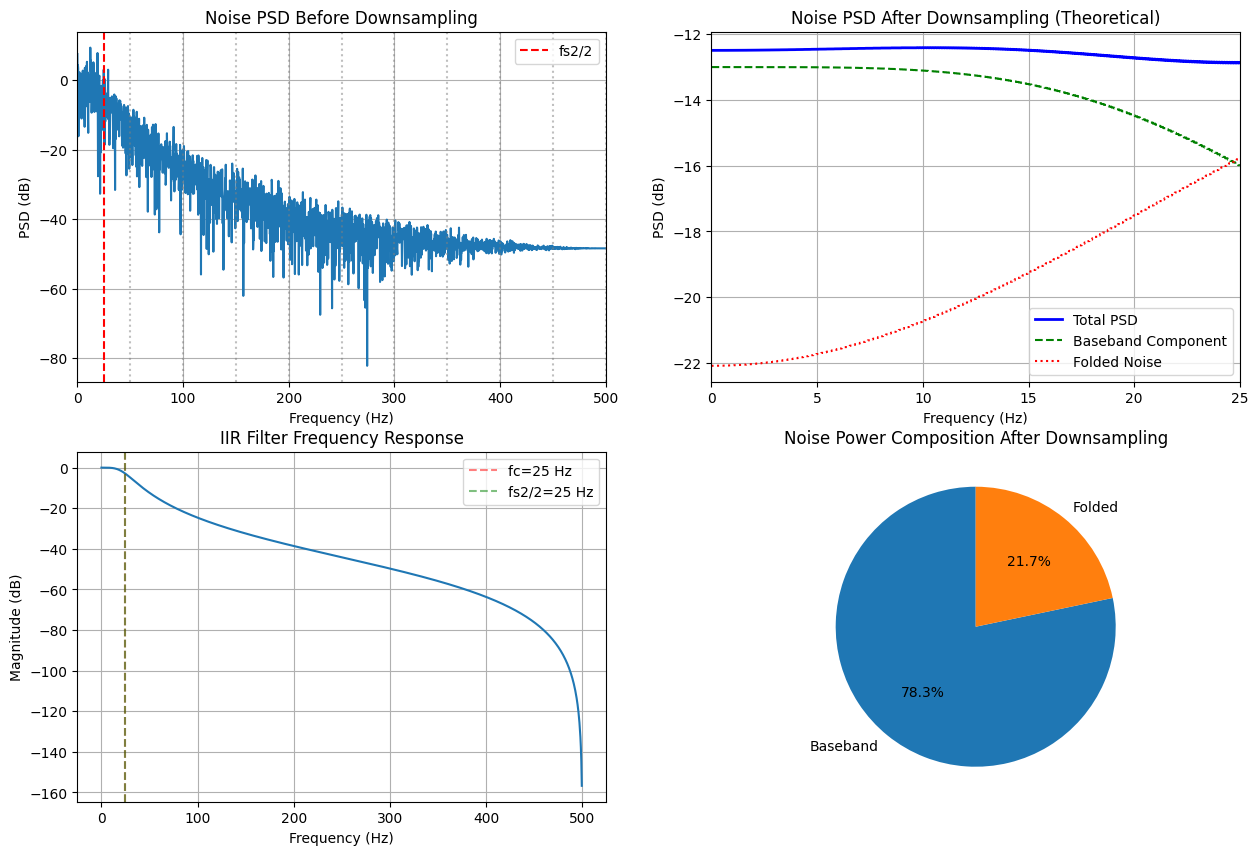

In [5]:
fs1 = 1000
fs2 = 50
fc = 25
mc_results, freq_results = run_complete_simulation(fs1, fs2, fc)

# 可视化
visualize_results(freq_results, fs1, fs2, fc)